<a href="https://colab.research.google.com/github/blueeagle100/stereo_vision_starter/blob/main/1_camera_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Camera Calibration**

In this tutorial we will learn about camera calibration in opencv

## **Background (Projection Matrix)**

From the forward Imaging Model we can transform a point from the 3D world to a digital pixel location using just the projection matrix $P$

$$
P = 
  \begin{bmatrix}
    p_{11} & p_{12} & p_{13} & p_{14} \\
    p_{21} & p_{22} & p_{23} & p_{24} \\
    p_{31} & p_{32} & p_{33} & p_{34} 
  \end{bmatrix}
$$ 

The problem in camera calibration is to estiamte the matrix $P$. We can make this easier by decomposing $P$ with [QR Decomposition](https://en.wikipedia.org/wiki/QR_decomposition)

$$ P = K R \bf{t} $$

where

$$
\begin{align*}
K &= \begin{bmatrix}
      f_x & 0 & o_x\\
      0 & f_y & o_y\\
      0 & 0 & 1
  \end{bmatrix}
  \quad\quad\; \text{  Is the Calibration Matrix (or Intrinsic Matrix)}
\\
R &= \begin{bmatrix} 
          r_{11} & r_{12} & r_{13} \\
          r_{21} & r_{22} & r_{23} \\
          r_{31} & r_{32} & r_{33} 
    \end{bmatrix}
    \qquad \text{Is the Rotation Matrix}
\\
\bf{t} &= \begin{bmatrix} t_x \\ t_y \\ tz \end{bmatrix}
\qquad\qquad\quad\qquad \text{Is the Translation Vector}
\end{align*}
$$

## **Background - Distortion Coefficients**

There are two main types of distortion, radial and tangential. Radial distortion causes straight lines to appear curved. Tangential distortion occurs due to the fact that the image-taking lens is not perfectly aligned to the image plane, causing some areas of the image to appear closer than expected.



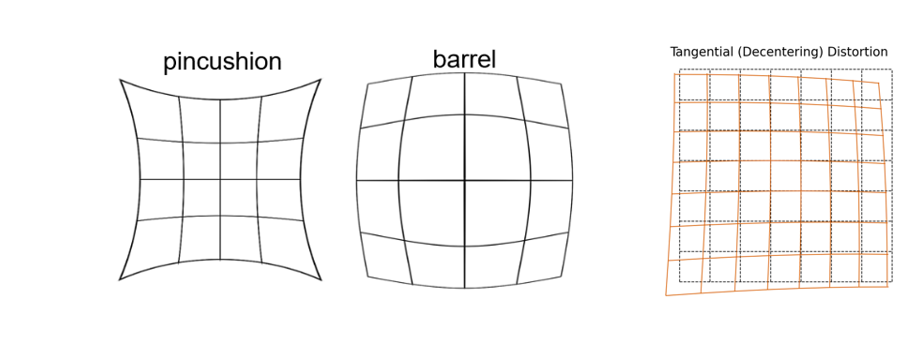

<p align="center">
    <br>
    <em> <b> Figure 1. (Right) Types of Radial Distortion. (Left) Tangential Distortion. </b> </em>
</p>

In part 0 we derived the projection matrix with the basic pinhole camera model. Recall from the pinhole camera model we have:

$$
u = f_x \frac{x_c}{z_c} + o_x \longrightarrow u = f_x x' + o_x
\\
v = f_y \frac{y_c}{z_c} + o_y \longrightarrow  v= f_y y' + o_y
$$

However we will need to modify $x'$ and $y'$ to account for lens distortion.

For radial distortion we can modify $x'$ and $y'$ as:

$$
x_{dist} = x'(1 + k_1 r^2 + k_2 r^4 + k_3 r_6)


\text{ where }
r^2 = x^2 + y^2
$$

## **Sources**
- https://web.stanford.edu/class/cs231a/course_notes/01-camera-models.pdf
- https://ori.codes/artificial-intelligence/camera-calibration/camera-distortions/
- https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html
- https://learnopencv.com/understanding-lens-distortion/
- https://www.tangramvision.com/blog/camera-modeling-exploring-distortion-and-distortion-models-part-i

If you would like some additional theory on how the projection matrix is estiamted please see this excellent [video](https://www.youtube.com/watch?v=GUbWsXU1mac&list=PL2zRqk16wsdoCCLpou-dGo7QQNks1Ppzo&index=3)

## **Calibration Procedure**

1. Capture an image of an object with known geometry (e.g. chessboard)
2.  


In [1]:
!wget https://stereo-vision.s3.eu-west-3.amazonaws.com/stereo_vision_data.zip

--2022-09-04 13:08:08--  https://stereo-vision.s3.eu-west-3.amazonaws.com/stereo_vision_data.zip
Resolving stereo-vision.s3.eu-west-3.amazonaws.com (stereo-vision.s3.eu-west-3.amazonaws.com)... 52.95.156.86
Connecting to stereo-vision.s3.eu-west-3.amazonaws.com (stereo-vision.s3.eu-west-3.amazonaws.com)|52.95.156.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135956624 (130M) [application/zip]
Saving to: ‘stereo_vision_data.zip’

stereo_vision_data. 100%[===================>] 129.66M  63.5MB/s    in 2.0s    

2022-09-04 13:08:10 (63.5 MB/s) - ‘stereo_vision_data.zip’ saved [135956624/135956624]



In [2]:
!jar xf stereo_vision_data.zip

## **Download the Data**
 Let's download the camera calibration data!

In [ ]:
!wget https://www.me.psu.edu/brennan/ME545/2012/FinalProjects/Mangus_3DCameraCalibration/Sample_Calibration_Images.zip

--2022-09-03 17:32:30--  https://www.me.psu.edu/brennan/ME545/2012/FinalProjects/Mangus_3DCameraCalibration/Sample_Calibration_Images.zip
Resolving www.me.psu.edu (www.me.psu.edu)... 146.186.145.12
Connecting to www.me.psu.edu (www.me.psu.edu)|146.186.145.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2160962 (2.1M) [application/x-zip-compressed]
Saving to: ‘Sample_Calibration_Images.zip’

Sample_Calibration_ 100%[===================>]   2.06M   397KB/s    in 7.2s    

2022-09-03 17:32:38 (295 KB/s) - ‘Sample_Calibration_Images.zip’ saved [2160962/2160962]



In [ ]:
!jar xf Sample_Calibration_Images.zip

#### Base Library Import

In [7]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

### Get data

In [10]:
!ls

__MACOSX  sample_data  stereo_vision_data  stereo_vision_data.zip


Number of Calibration Images: 30


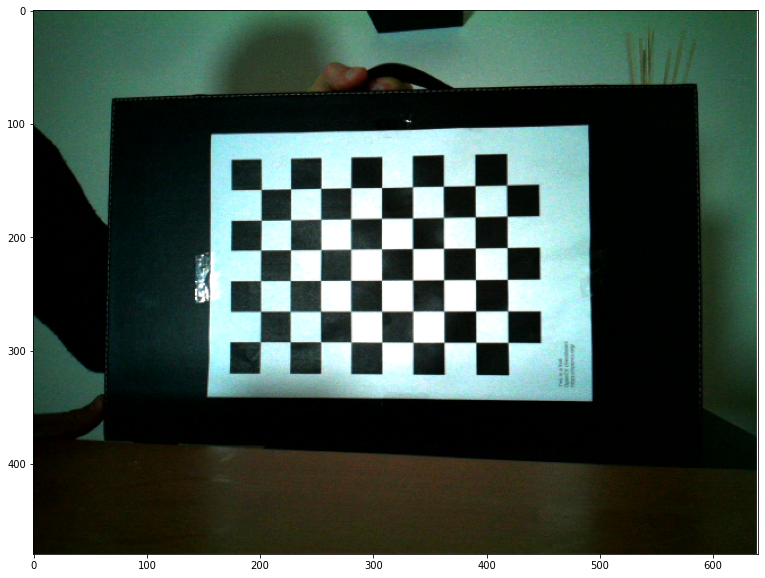

In [13]:
calibration_images = glob('stereo_vision_data/Calibration/Image Pairs/pairs/left_*.png')

print(f'Number of Calibration Images: {len(calibration_images)}')


plt.imshow(mpimg.imread(calibration_images[21]))
plt.show()

### Get some info about our calibration object

In [14]:
square_size = 24 # square size in mm
rows = 6
columns = 9